In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        (os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Import libraries

In [2]:
import matplotlib.pyplot as plt  # plotting library
import scipy                     # scientific computnig and technical computing
import cv2                       # working with, mainly resizing, images
import numpy as np               # dealing with arrays
import glob                      # return a possibly-empty list of path names that match pathname
import os                        # dealing with directories
import pandas as pd              # providing data structures and data analysis tools
import tensorflow as tf       
import itertools
import random
from random import shuffle       # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm            # a nice pretty percentage bar for tasks. Thanks to viewer Daniel Bühler for this suggestion
from PIL import Image
from scipy import ndimage
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
%matplotlib inline
np.random.seed(1)

In [3]:

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Fetching the required train and test folder

In [4]:
train_dir = '../input/object-detection/Training_set/Training_set'
test_dir = '../input/object-detection/test/test'

# checking the subdirectories in Train and test dir

In [5]:
os.listdir(train_dir)


['electric car', 'electric bus']

In [51]:
for i in os.listdir(train_dir):
    print(i,len(os.path.join(train_dir,i)))

electric car 64
electric bus 64


In [6]:
os.listdir(test_dir)

['electric car', 'electric bus']

In [52]:
for i in os.listdir(test_dir):
    print(i,len(os.path.join(train_dir,i)))

electric car 64
electric bus 64


# The data is very less to train so we need to perform data augmentation

In [7]:
height=150
width=150
channels=3
seed=1337
batch_size = 64
num_classes = 2
epochs = 50
data_augmentation = True
num_predictions = 20


In [8]:
# Training generator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(height,width),
                                                    batch_size=batch_size,
                                                    seed=seed,
                                                    shuffle=True,
                                                    class_mode='categorical')


Found 1486 images belonging to 2 classes.


In [39]:
# Test generator
test_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size=(height,width), 
                                                  batch_size=batch_size,
                                                  seed=seed,
                                                  shuffle=True,
                                                  class_mode='categorical')

train_num = train_generator.samples
validation_num = validation_generator.samples

Found 382 images belonging to 2 classes.


# Creating the Network using Keras

In [10]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))



model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))



model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))




model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# Compiling the network

In [11]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 36, 64)        1

In [12]:
filepath=str(os.getcwd()+"\vehicle.h5f")
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
# = EarlyStopping(monitor='val_acc', patience=15)
callbacks_list = [checkpoint]#, stopper]

In [13]:
history = model.fit_generator(train_generator,
                              steps_per_epoch= train_num // batch_size,
                              epochs=epochs,
                              validation_data=train_generator,
                              validation_steps= validation_num // batch_size,
                                                              
                             callbacks=callbacks_list,
                              verbose = 1
                             )

Epoch 1/50
23/23 [==============================] - ETA: 0s - loss: 0.7051 - acc: 0.5063
Epoch 00001: val_acc improved from -inf to 0.64688, saving model to /kaggle/workingehicle.h5f
23/23 [==============================] - 18s 768ms/step - loss: 0.7051 - acc: 0.5063 - val_loss: 0.6548 - val_acc: 0.6469
Epoch 2/50
23/23 [==============================] - ETA: 0s - loss: 0.6438 - acc: 0.6378
Epoch 00002: val_acc did not improve from 0.64688
23/23 [==============================] - 15s 648ms/step - loss: 0.6438 - acc: 0.6378 - val_loss: 0.6039 - val_acc: 0.6406
Epoch 3/50
23/23 [==============================] - ETA: 0s - loss: 0.6068 - acc: 0.6660
Epoch 00003: val_acc improved from 0.64688 to 0.72812, saving model to /kaggle/workingehicle.h5f
23/23 [==============================] - 17s 760ms/step - loss: 0.6068 - acc: 0.6660 - val_loss: 0.5512 - val_acc: 0.7281
Epoch 4/50
23/23 [==============================] - ETA: 0s - loss: 0.5796 - acc: 0.6997
Epoch 00004: val_acc did not improv

23/23 [==============================] - ETA: 0s - loss: 0.3562 - acc: 0.8481
Epoch 00030: val_acc did not improve from 0.90938
23/23 [==============================] - 16s 681ms/step - loss: 0.3562 - acc: 0.8481 - val_loss: 0.3034 - val_acc: 0.8687
Epoch 31/50
23/23 [==============================] - ETA: 0s - loss: 0.3269 - acc: 0.8594
Epoch 00031: val_acc did not improve from 0.90938
23/23 [==============================] - 15s 652ms/step - loss: 0.3269 - acc: 0.8594 - val_loss: 0.3065 - val_acc: 0.8719
Epoch 32/50
23/23 [==============================] - ETA: 0s - loss: 0.3148 - acc: 0.8748
Epoch 00032: val_acc did not improve from 0.90938
23/23 [==============================] - 15s 643ms/step - loss: 0.3148 - acc: 0.8748 - val_loss: 0.4957 - val_acc: 0.7750
Epoch 33/50
23/23 [==============================] - ETA: 0s - loss: 0.3111 - acc: 0.8692
Epoch 00033: val_acc did not improve from 0.90938
23/23 [==============================] - 16s 701ms/step - loss: 0.3111 - acc: 0.8692 -

Store the model in current working directory

In [53]:
model.save('cars_buses.h5')

# Plot the results

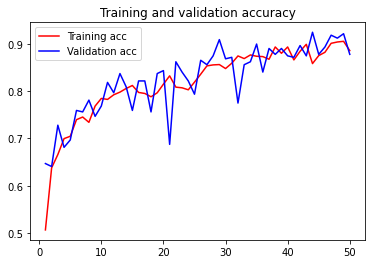

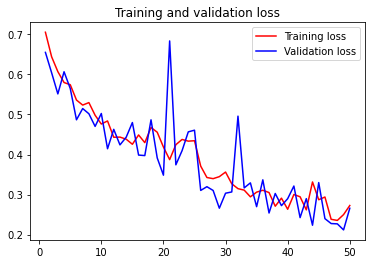

In [14]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

# Evaluating the model

In [43]:
predictions = model.predict_classes(validation_generator)

In [41]:
x,y=validation_generator.next()

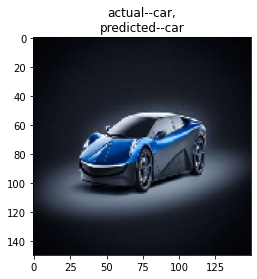

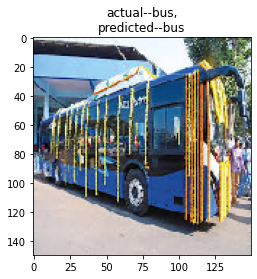

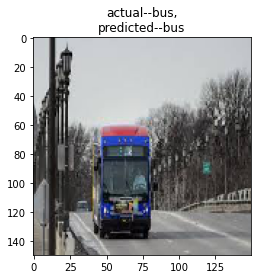

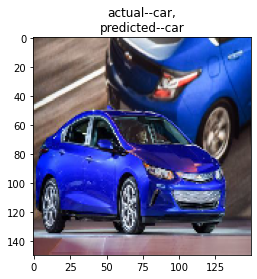

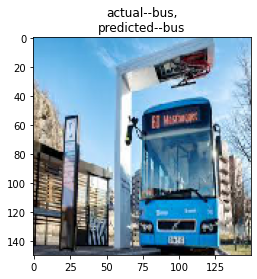

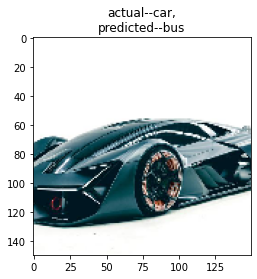

In [47]:
for i in range(0,6):
    image = x[i]
    image_label=y[i]
    image_label='bus' if image_label[0]==1 else 'car'
    pred=predictions[i]
    pred='bus' if pred==0 else 'car'
    #print('output',image_label)
    plt.title(f"actual--{image_label},\npredicted--{pred}")
    plt.imshow(image)
    plt.show()